In [153]:
import numpy as np
import matplotlib.pyplot as plt
import trimesh as tri
import torch

from utils import mesh_processing

# On a curve

### Create the test curve: a circle

In [154]:
scale = 12
theta = np.arange(0,(2*np.pi)/scale*(scale+1),(2*np.pi)/scale)
points_x, points_y = np.cos(theta), np.sin(theta)

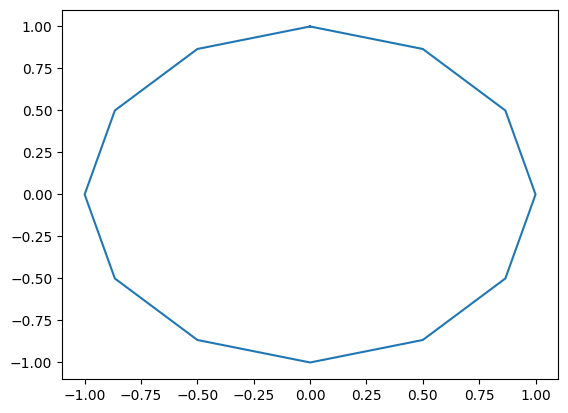

In [155]:
plt.plot(points_y, points_x)

In [275]:
positions = np.vstack((points_x, points_y)).T
positions = torch.Tensor(positions).to('cpu')

In [276]:
def get_center_length_tangent(curve, device='cpu'):
    
    id_start = torch.arange(0, curve.shape[0]-1).to(dtype=torch.long, device=device)
    id_end = torch.arange(1, curve.shape[0]).to(dtype=torch.long, device=device)
    
    V_start, V_end = curve[id_start], curve[id_end]

    centers = (V_start + V_end)/2
    lengths = ((V_end - V_start)**2).sum(dim=1)[:, None].sqrt()
    tangents = (V_end - V_start)/(lengths + 1e-10)
    
    return(centers, lengths, tangents)

In [277]:
c, l, t = get_center_length_tangent(positions)

In [278]:
ref_t = torch.Tensor([1.,0.]).to('cpu')
ref_t_list = ref_t.repeat(t.shape[0], 1)

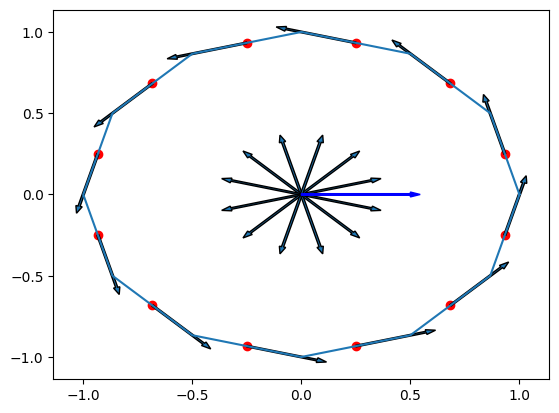

In [279]:
plt.plot(positions[:,0], positions[:,1])
plt.scatter(c[:,0], c[:,1], c='r')
for i in range(l.size()[0]):
    plt.arrow(c[i,0], c[i,1], t[i,0]/3, t[i,1]/3, width=0.01)
    plt.arrow(0, 0, t[i,0]/3, t[i,1]/3, width=0.01)
    
plt.arrow(0,0, ref_t[0]/2, ref_t[1]/2, width=0.01, color='b')
plt.show()

In [281]:
angle = torch.arccos(torch.clip(torch.dot(t[0,:], ref_t), -1.0, 1.0))

In [282]:
angle

tensor(1.8326)

In [197]:
def gauss_kernel(x,y,sigma):

    return(np.exp(-((x - y).norm()/sigma)**2))

def lin_kernel(u,v):
    return(np.inner(u,v))

In [289]:
def varifold_transform(x,t_x, c, l, t, sigma = 0.2):
    S = 0
    for k in range(len(l)):
        
        S += l[k]*gauss_kernel(x,c[k], sigma)*lin_kernel(t_x, t[k])
    
    return S[0]

In [290]:
def varifold_transform_position_only(x, c, l, sigma = 0.2):
    S = 0
    for k in range(len(l)):
        
        S += l[k]*gauss_kernel(x,c[k], sigma)
    
    return S[0]

In [304]:
import time
x, t_x = c[0], t[0]

start_time = time.time()
print(varifold_transform(x, t_x, c, l, t))
print("Time: " + str(time.time() - start_time))

tensor(0.5194)
Time: 0.0073468685150146484


In [305]:
x

tensor([0.9330, 0.2500])

In [345]:
X, Y = torch.arange(-1,1,0.05), torch.arange(-1,1,0.05)

In [379]:
i, j = 0, 0
res = []

for i in range(X.shape[0]):
    inter = []
    for j in range(Y.shape[0]):
        point = torch.Tensor([X[i].item(), Y[j].item()])
        val = varifold_transform_position_only(point, c, l, sigma = 0.3)
        inter.append(val)
    res.append(inter)

In [380]:
res_tens = torch.Tensor(res)

In [381]:
res_tens.shape

torch.Size([40, 40])

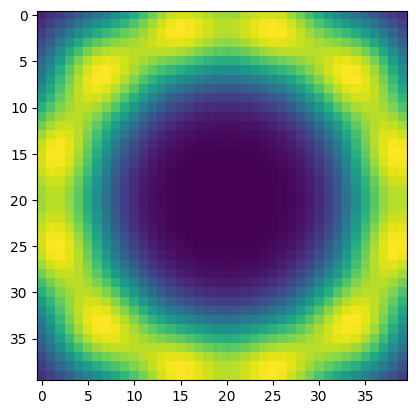

In [382]:
plt.imshow(res_tens)

# On a mesh

In [2]:
mesh = tri.load_mesh("./data/test_data/bunny.ply")

In [3]:
ref_point = mesh.triangles_center[0]
dual_mesh = mesh.triangles_center
true_triangles = mesh.triangles

In [5]:
dual_mesh.shape

(69451, 3)

In [6]:
true_triangles.shape

(69451, 3, 3)

In [7]:
def closest_node(node, nodes):
    nodes = np.asarray(nodes)
    deltas = nodes - node
    dist_2 = np.einsum('ij,ij->i', deltas, deltas)
    return np.argpartition(dist_2, 3)[:3]

In [8]:
recons_triangles = np.zeros((true_triangles.shape))

In [13]:
recons_triangles = np.array([closest_node(node, mesh.vertices) for node in dual_mesh[:10]])

In [14]:
recons_triangles

array([[20462, 20463, 19669],
       [14299,  8935,  8845],
       [ 4984, 12949, 15446],
       [15447, 15446,  4984],
       [20172, 20171, 20254],
       [22324, 14686, 22609],
       [29534, 29483, 26417],
       [ 7016,  7018, 20707],
       [12255, 12343, 12613],
       [12317,  4490, 16344]])

In [18]:
print(mesh.vertices[20462])
print(mesh.vertices[20463])
print(mesh.vertices[19669])

[-0.0921802  0.132348   0.0172238]
[-0.0923144  0.132364   0.0182222]
[-0.0927674  0.130992   0.0172311]


In [19]:
true_triangles[0]

array([[-0.0927674,  0.130992 ,  0.0172311],
       [-0.0921802,  0.132348 ,  0.0172238],
       [-0.0923144,  0.132364 ,  0.0182222]])

array([20462, 20463, 19669])

0.0010269673764337235